In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["from", "subject", "re", "edu", "use"])

In [3]:
df_indeed_list = pd.read_csv("data/indeed_data_scientist_list.csv")
df_linkedin_list = pd.read_csv("data/linkedin_data_scientist_list.csv")
df_list = pd.concat([df_indeed_list, df_linkedin_list], axis=0)
df_list.drop_duplicates(subset=["title", "company", "text"], keep="first", inplace=True)
df_list.dropna(subset=["text"], inplace=True)
df_list.reset_index(inplace=True, drop=True)

In [4]:
data = [". ".join(df_list.text.values.tolist())]

In [5]:
# data = df_list.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


<>:4: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-83b79b35a7ac>:4: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-5-83b79b35a7ac>:7: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [6]:
# print(df["text"].loc[0])

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['using', 'machine', 'learning', 'and', 'other', 'data', 'mining', 'techniques', 'to', 'get', 'insights', 'from', 'massive', 'datasets', 'such', 'as', 'identifying', 'fraud', 'rings', 'understanding', 'what', 'problems', 'create', 'consumer', 'calls', 'through', 'data', 'mining', 'interaction', 'records', 'analyzing', 'online', 'banking', 'patterns', 'mining', 'vast', 'amounts', 'of', 'data', 'to', 'identify', 'trends', 'in', 'credit', 'risk', 'using', 'combination', 'of', 'quantitative', 'analysis', 'and', 'statistical', 'methods', 'to', 'develop', 'strategic', 'insights', 'and', 'recommendations', 'to', 'optimize', 'products', 'or', 'programs', 'adapting', 'the', 'latest', 'technologies', 'in', 'modelling', 'and', 'data', 'mining', 'to', 'design', 'scientific', 'tests', 'that', 'optimize', 'dollars', 'spent', 'on', 'new', 'initiatives', 'and', 'marketing', 'channels', 'building', 'statistical', 'models', 'to', 'form', 'the', 'foundation', 'of', 'business', 'decisions', 'and', 'regul

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=80) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['using', 'machine_learning', 'and', 'other', 'data', 'mining', 'techniques', 'to', 'get', 'insights', 'from', 'massive', 'datasets', 'such', 'as', 'identifying', 'fraud', 'rings', 'understanding', 'what', 'problems', 'create', 'consumer', 'calls', 'through', 'data', 'mining', 'interaction', 'records', 'analyzing', 'online', 'banking', 'patterns', 'mining', 'vast', 'amounts', 'of', 'data', 'to', 'identify', 'trends', 'in', 'credit_risk', 'using', 'combination', 'of', 'quantitative', 'analysis', 'and', 'statistical', 'methods', 'to', 'develop', 'strategic', 'insights', 'and', 'recommendations', 'to', 'optimize', 'products', 'or', 'programs', 'adapting', 'the', 'latest', 'technologies', 'in', 'modelling', 'and', 'data', 'mining', 'to', 'design', 'scientific', 'tests', 'that', 'optimize', 'dollars', 'spent', 'on', 'new', 'initiatives', 'and', 'marketing', 'channels', 'building', 'statistical', 'models', 'to', 'form', 'the', 'foundation', 'of', 'business', 'decisions', 'and', 'regularly', 

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# # Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en_trf_xlnetbasecased_lg', disable=['parser', 'ner'])
# nlp = spacy.load('en_trf_xlnetbasecased_lg')


# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# # print(data_lemmatized)

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

[['use', 'machine_learne', 'datum', 'mining', 'technique', 'get', 'insight', 'massive', 'dataset', 'identify', 'fraud', 'ring', 'understanding', 'problem', 'create', 'consumer', 'call', 'datum', 'mining', 'interaction', 'record', 'analyze', 'online', 'banking', 'pattern', 'mine', 'vast', 'amount', 'datum', 'identify', 'trend', 'credit_risk', 'use', 'combination', 'quantitative', 'analysis', 'statistical', 'method', 'develop', 'strategic', 'insight', 'recommendation', 'optimize', 'product', 'program', 'adapt', 'late', 'technology', 'model', 'datum', 'mining', 'design', 'scientific', 'test', 'optimize', 'dollar', 'spend', 'new', 'initiative', 'marketing', 'channel', 'build', 'statistical', 'model', 'form', 'foundation', 'business', 'decision', 'regularly', 'monitor', 'performance', 'model', 'corrective', 'action', 'take', 'currently_enrolle', 'undergraduate', 'master', 'program', 'graduate', 'pursue', 'degree', 'mathematic', 'statistic', 'engineer', 'experience', 'analyze', 'datum', 'set

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=30,
                                           chunksize=100,
                                           passes=30,
                                            iterations=150,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"experience" + 0.026*"datum" + 0.015*"work" + 0.010*"business" + '
  '0.010*"team" + 0.009*"model" + 0.009*"skill" + 0.007*"development" + '
  '0.007*"ability" + 0.007*"data"'),
 (1,
  '0.000*"datum" + 0.000*"experience" + 0.000*"work" + 0.000*"business" + '
  '0.000*"skill" + 0.000*"model" + 0.000*"develop" + 0.000*"data" + '
  '0.000*"knowledge" + 0.000*"ability"')]


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007523 -0.132758       1        1  99.999390
1      0.007523  0.132758       2        1   0.000609, topic_info=     Category         Freq         Term        Total  loglift  logprob
3215  Default   278.000000      provide   278.000000  30.0000  30.0000
1065  Default  1979.000000        datum  1979.000000  29.0000  29.0000
3786  Default   273.000000     software   273.000000  28.0000  28.0000
2251  Default   413.000000    knowledge   413.000000  27.0000  27.0000
3264  Default   179.000000      quality   179.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
1181   Topic2     0.000109  development   544.767151  -3.4174  -8.3607
3136   Topic2     0.000109      process   366.893036  -3.0233  -8.3619
3786   Topic2     0.000109     software   273.582367  -2.7313  -8.3634
1034   Topic2     0.000108     customer   299.826813  -2.8242  -8.3646
4019   Topic2     0.000108       system   289.135284  -2.7885  -8.3653

[124 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         1  0.999613      ability
98        1  0.998099     advanced
185       1  1.000057     analysis
187       1  0.998699     analytic
222       1  0.998184  application
...     ...       ...          ...
4388      1  0.690024   vulnerable
4409      1  0.690023       weapon
4459      1  1.000008         work
4461      1  0.690023     workbook
4489      1  1.000750         year

[90 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

---

In [41]:
# Load the regular expression library
import re# Remove punctuation
df_list['text_processed'] = df_list['text'].map(lambda x: re.sub(r'[,\.!?]', '', x))# Convert the titles to lowercase
df_list['text_processed'] = df_list['text_processed'].map(lambda x: x.lower())# Print out the first rows of papers
df_list['text_processed'].head()

0     using machine learning and other data mining ...
1     master’s degree in statistics operations rese...
2     using machine learning and other data mining ...
3     join a world-class team of machine learning r...
4    partner with business development teams to cre...
Name: text_processed, dtype: object

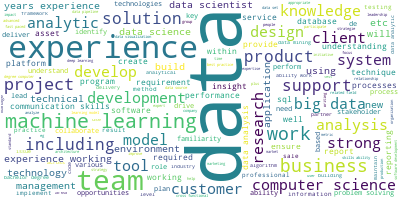

In [42]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(df_list['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

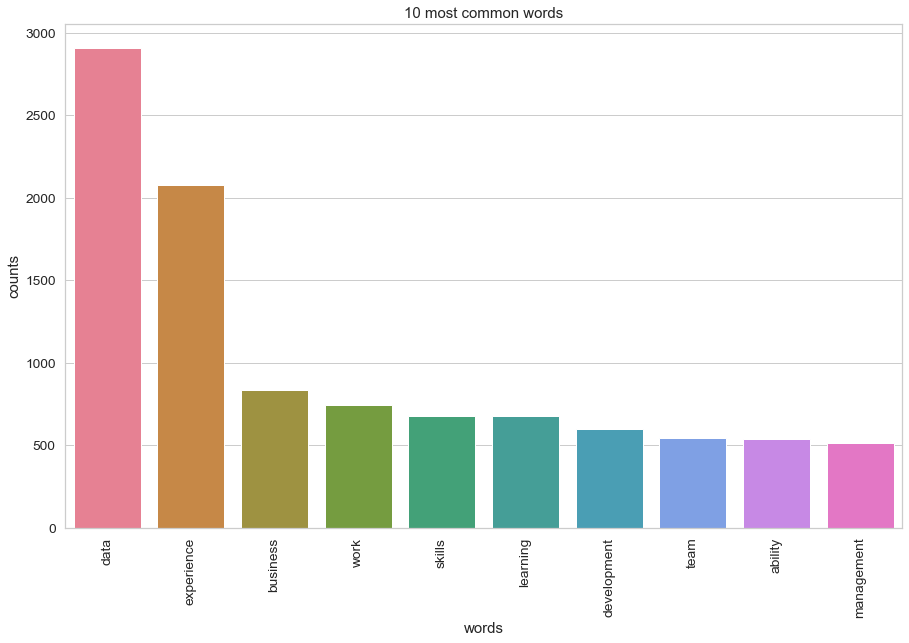

In [52]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline  
# Helper function

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
    
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_list['text_processed'])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [65]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2
number_words = 20 # Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
data experience business learning skills work development machine working management ability analysis knowledge team strong years models science tools technical

Topic #1:
experience work team data design product ability et science development environment digital des web paid strong life code technical skills


In [66]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer) 

LDAvis_prepared


Wall time: 1min 46s


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
0      0.098878  0.0       1        1  85.66578
1     -0.098878  0.0       2        1  14.33422, topic_info=     Category         Freq        Term        Total  loglift  logprob
2429  Default  1962.000000  experience  1962.000000  30.0000  30.0000
6273  Default   506.000000        team   506.000000  29.0000  29.0000
6870  Default   694.000000        work   694.000000  28.0000  28.0000
1831  Default   376.000000      design   376.000000  27.0000  27.0000
4906  Default   262.000000     product   262.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
878    Topic2    32.490634       build   229.731485  -0.0134  -6.0060
6275   Topic2    32.152183       teams   233.643818  -0.0408  -6.0165
5839   Topic2    34.798135      skills   644.593929  -0.9765  -5.9374
3208   Topic2    31.584832   including   346.007333  -0.4513  -6.0343
4196   Topic2    31.050399         new   328.858688  -0.4175  -6.0514

[171 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
96        1  0.887836     ability
96        2  0.110980     ability
325       1  0.991696  algorithms
325       2  0.013311  algorithms
374       1  0.989083    analysis
...     ...       ...         ...
6870      2  0.126753        work
6882      1  0.961416     working
6882      2  0.037621     working
6926      1  0.936485       years
6926      2  0.064816       years

[227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_data_filepath = os.path.join(f'./ldavis_prepared_{number_topics}')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer) 
    
with open(LDAvis_data_filepath, 'w') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

---

In [67]:
#Fetch wordcount for each abstract
df_list['word_count'] = df_list["text"].apply(lambda x: len(str(x).split(" ")))

In [71]:
#Identify common words
freq = pd.Series(' '.join(df_list["text"]).split()).value_counts()[:20]

In [76]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(df_list["text"]).split()).value_counts()[-20:]

In [77]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [89]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

In [79]:
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [92]:
corpus = []
for i in range(len(df_list["text"])):
    #Remove punctuations
    text = re.sub(r'[^a-zA-Z]', ' ', df_list["text"][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub(r"&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub(r"(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [96]:
corpus[150]

'prepare invoice billing maintain accurate account receivable ledger track make collection ongoing basis ensure revenue promptly collected accurately reconciled liaise research financial service r needed review assigned account financial report fund account statement statistic bank statement etc reconcile general ledger assigned analyzes balance information transaction verify accuracy reasonability completeness identifies discrepancy investigates obtain explanation missing information correction well notifying supervisor manager unresolved discrepancy support research operation principal investigator financial management grant program budget expense prepares make presentation manager director complex analysis report providing thorough informative explanation result manage large access database analyzes interprets data produce report identifies trend significant transaction deviation standard recommends action taken assist forecast preparation budget review conduct assist special projec

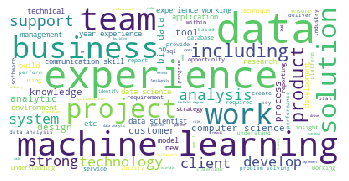

In [98]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
import re

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [103]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

[Text(0, 0, 'data'),
 Text(0, 0, 'experience'),
 Text(0, 0, 'business'),
 Text(0, 0, 'team'),
 Text(0, 0, 'work'),
 Text(0, 0, 'skill'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'model'),
 Text(0, 0, 'development'),
 Text(0, 0, 'ability'),
 Text(0, 0, 'year'),
 Text(0, 0, 'analysis'),
 Text(0, 0, 'management'),
 Text(0, 0, 'working'),
 Text(0, 0, 'machine'),
 Text(0, 0, 'science'),
 Text(0, 0, 'strong'),
 Text(0, 0, 'project'),
 Text(0, 0, 'knowledge'),
 Text(0, 0, 'product')]

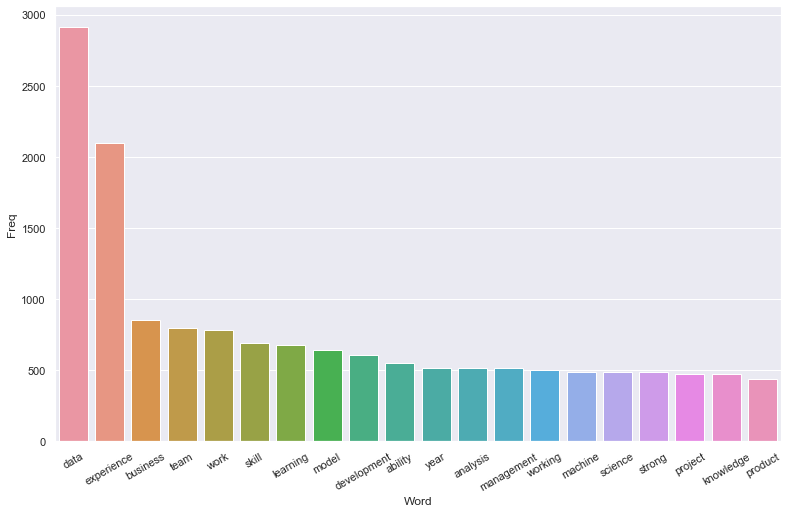

In [104]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                Bi-gram  Freq
0      machine learning   474
1      computer science   232
2              big data   209
3       year experience   200
4    experience working   181
5          data science   174
6   communication skill   163
7        data scientist   157
8         data analysis   116
9       problem solving   109
10      experience data   100
11      bachelor degree    87
12         ability work    86
13       data analytics    79
14        skill ability    79
15          data mining    78
16        best practice    78
17      degree computer    76
18             data set    75
19        deep learning    74


[Text(0, 0, 'machine learning'),
 Text(0, 0, 'computer science'),
 Text(0, 0, 'big data'),
 Text(0, 0, 'year experience'),
 Text(0, 0, 'experience working'),
 Text(0, 0, 'data science'),
 Text(0, 0, 'communication skill'),
 Text(0, 0, 'data scientist'),
 Text(0, 0, 'data analysis'),
 Text(0, 0, 'problem solving'),
 Text(0, 0, 'experience data'),
 Text(0, 0, 'bachelor degree'),
 Text(0, 0, 'ability work'),
 Text(0, 0, 'data analytics'),
 Text(0, 0, 'skill ability'),
 Text(0, 0, 'data mining'),
 Text(0, 0, 'best practice'),
 Text(0, 0, 'degree computer'),
 Text(0, 0, 'data set'),
 Text(0, 0, 'deep learning')]

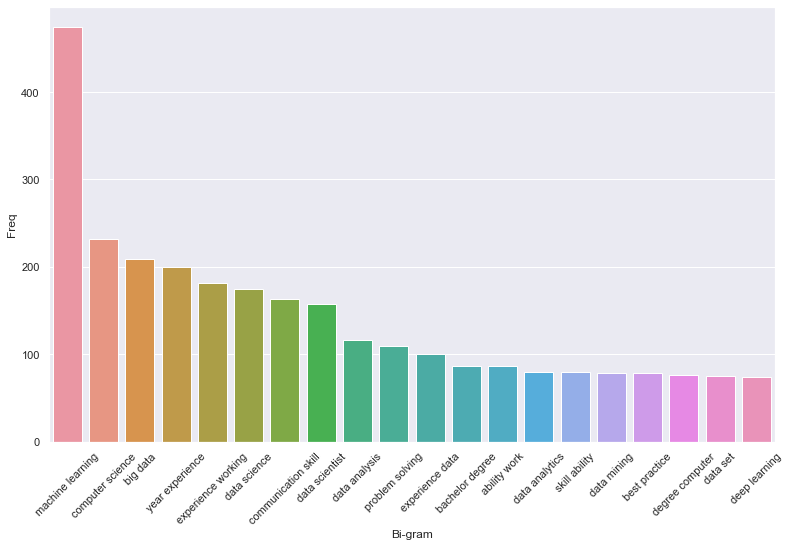

In [106]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0        degree computer science    69
1         machine learning model    68
2   computer science engineering    47
3          problem solving skill    47
4    written communication skill    44
5          cross functional team    44
6    natural language processing    41
7            big data technology    39
8   engineering computer science    38
9            experience big data    36
10  verbal written communication    35
11      computer science related    33
12    machine learning technique    33
13        fast paced environment    32
14  written verbal communication    31
15   communication skill ability    31
16    machine learning algorithm    29
17    analytical problem solving    29
18    verbal communication skill    29
19       minimum year experience    29


[Text(0, 0, 'degree computer science'),
 Text(0, 0, 'machine learning model'),
 Text(0, 0, 'computer science engineering'),
 Text(0, 0, 'problem solving skill'),
 Text(0, 0, 'written communication skill'),
 Text(0, 0, 'cross functional team'),
 Text(0, 0, 'natural language processing'),
 Text(0, 0, 'big data technology'),
 Text(0, 0, 'engineering computer science'),
 Text(0, 0, 'experience big data'),
 Text(0, 0, 'verbal written communication'),
 Text(0, 0, 'computer science related'),
 Text(0, 0, 'machine learning technique'),
 Text(0, 0, 'fast paced environment'),
 Text(0, 0, 'written verbal communication'),
 Text(0, 0, 'communication skill ability'),
 Text(0, 0, 'machine learning algorithm'),
 Text(0, 0, 'analytical problem solving'),
 Text(0, 0, 'verbal communication skill'),
 Text(0, 0, 'minimum year experience')]

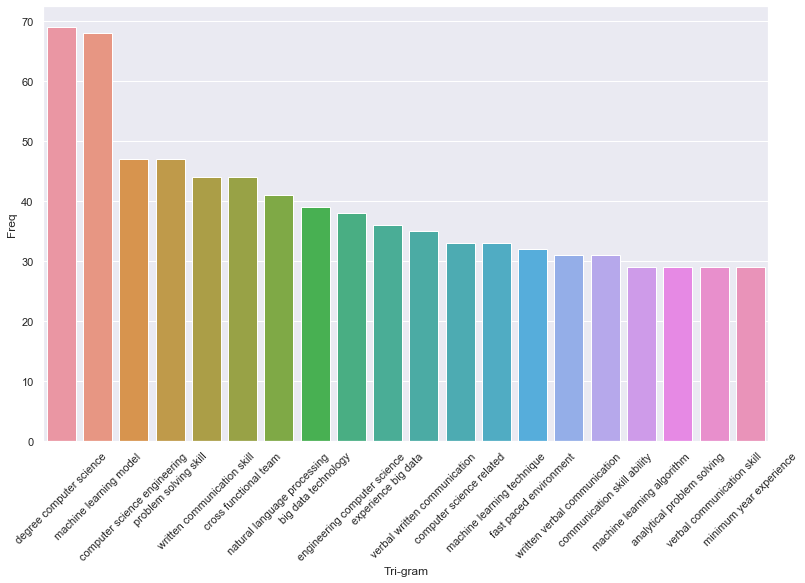

In [108]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]

print(top3_df)#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [110]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[255]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [112]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
work domain expert analyze manage time series data global water industry work data engineer data scientist domain expert build evaluate deploy maintain high performance machine learning model work back end developer design build scalable robust computationally intensive technology near real time execution bachelor advanced degree computer science software engineering data science statistic mathematics equivalent required master level degree data science nice year experience data science software engineering experience python data science library numpy panda scipy tensorflow pytorch scikit learn etc proficiency python java scala r equivalent extensive experience connecting various data source structure apis sql nosql blob storage etc experience end end modelling process data analysis data cleaning feature engineering modelling testing validation experience building time series model using ml algorithm preferred strong knowledge optimization classification clustering machine l